In [1]:
from numpy import tan, pi, sqrt
from scipy.optimize import minimize
from scipy.constants import e,h,hbar,k,G,epsilon_0
phi_0 = hbar/2./e
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qutip import *
from scipy import signal
import matplotlib as mpl
import time
mpl.rcParams['axes.linewidth'] = 2
import plots

In [2]:
def fluxmod(t, arg):
    return amp*np.cos(2*np.pi*omega*t)

In [3]:
# qubit (a)
amp=1*1e8 # qubity frequency modulation
fq = 7e9-amp # qubit frequency
Aq = 300e6 # higher order anharmonicity in Hamiltonian
gamma = 1e1 # qubit relaxation/excitation rate
gamma1= 100 # qubit dephasing rate

# cavity (b)   
fc = 7.1e9 # cavity frequency
kappa = 1e1 # cavity relaxation rate
cavity_spec = 3 # number of cavity levels

g=2*np.pi*1e+6
omega=fc-fq
psi0 = tensor(basis(2,0),basis(cavity_spec,0))      # initial state
tlist = np.linspace(0.0*1e-9, 1*1e-6, 1000)

ex_ops = ['sx', 'sz', 'num_b'] # operators of which to calculated expectation values

In [4]:
def qubit_integrate(fq, fc, Aq, g, tlist, ex_ops):
    
    b = tensor(qeye(2), destroy(cavity_spec)) # lowers cavity level
    sx = tensor(sigmax(),qeye(cavity_spec)) # determines x-projection of qubit level
    sz = tensor(sigmaz(),qeye(cavity_spec)) # determines y_projection of qubit level
    sm = tensor(destroy(2),qeye(cavity_spec)) # lowers qubit level
    num_b = b.dag()*b # cavity number operator
   

    
    H0 = 2*np.pi*(fq)*0.5*sz+2*np.pi*(fc)*num_b + g*(b+b.dag())*sx # time-independent Hamiltonian
    H1 = 2*np.pi*0.5*sz # time-dependent Hamiltonian, to be evolved with fluxmod
    
    H = [H0, [H1, fluxmod]] # total Hamiltonian
    
    # collapse operators
    c_op_list = []
    n_th = 0.0 # zero temperature

    # relaxation
    rate = gamma * (1 + n_th)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm)
    # excitation
    rate = gamma * n_th
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm.dag())
    # dephasing 
    rate = gamma1
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sz)
    # cavity relaxation
    rate = kappa
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * b)
    
    e_ops = []
    if 'sx' in ex_ops:
        e_ops.append(sx)
    if 'sy' in ex_ops:
        e_ops.append(sy)
    if 'sz' in ex_ops:
        e_ops.append(sz)
    if 'sm' in ex_ops:
        e_ops.append(sm)
    if 'num_b' in ex_ops:
        e_ops.append(num_b)
    output = mesolve(H, psi0, tlist, c_op_list, e_ops)
    return output  

In [5]:
output = qubit_integrate(fq,fc,Aq,g,tlist, ex_ops)

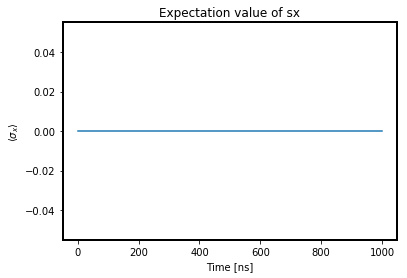

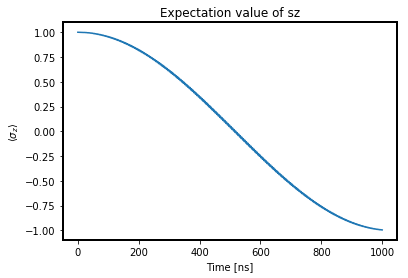

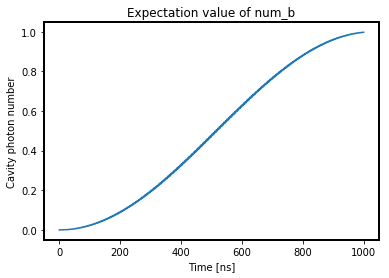

In [6]:
plots.expect(output.expect, tlist, 'sx', ex_ops)
plots.expect(output.expect, tlist, 'sz', ex_ops)
plots.expect(output.expect, tlist, 'num_b', ex_ops)

In [7]:
ex_ops = []
output = qubit_integrate(fq,fc,Aq,g,tlist, ex_ops)

Density matrix:
[[ 0.52+0.j  0.00+0.j  0.00-0.j]
 [ 0.00+0.j  0.48+0.j  0.00+0.j]
 [ 0.00+0.j  0.00+0.j  0.00+0.j]]


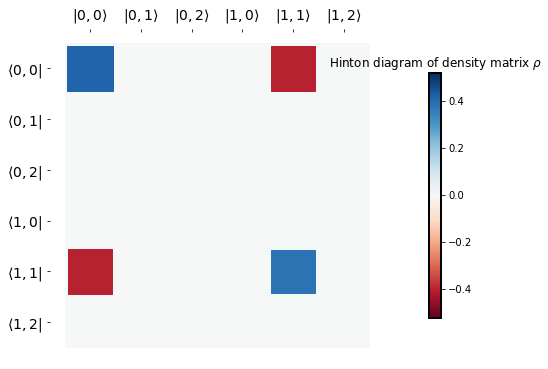

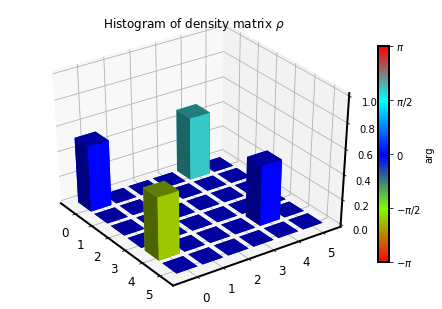

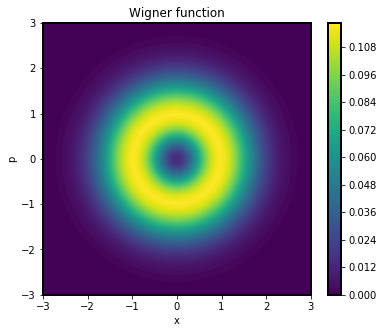

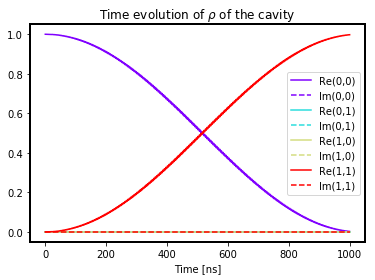

In [8]:
ind = 500 # time index to plot
obj = 1 # 0 = qubit, 1 = cavity

dm = plots.dmat(output.states, obj=obj, ind=ind, roff=2)
plots.dmat_hinton(output.states, ind)
plots.dmat_hist(output.states, ind, im=True)
cont0 = plots.wigner(output.states, obj=obj, ind=ind)
plots.dmatf(output.states, tlist, obj=obj, elems=[[0,0], [0,1], [1,0], [1,1]], obj_descr='cavity')